# CIV250 - Water Survey Analysis

Welcome! This exercise will help walk you through how to find and download hydrometric data from the Ministry of Environment, and do some clean up and basic manipulation of it on Python. The Ministry of Environment collects data from 1900 hydrometric stations across the country, many of which output data every 5 minutes! With so much data, it helps to use a program like Python to parse through it all.

Before we start, we should import the required python packages. We'll need numpy, pandas, and matplotlib, as well as the datetime package.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time

Now, we need to find a suitable station. Click [here](https://wateroffice.ec.gc.ca/my_station_list/index_e.html) to access the MOE's database. From here, select "Real-time Map Search" and pick "Ontario" from the drop-down menu to view all the hydrometric stations in the province. You should see something like this:

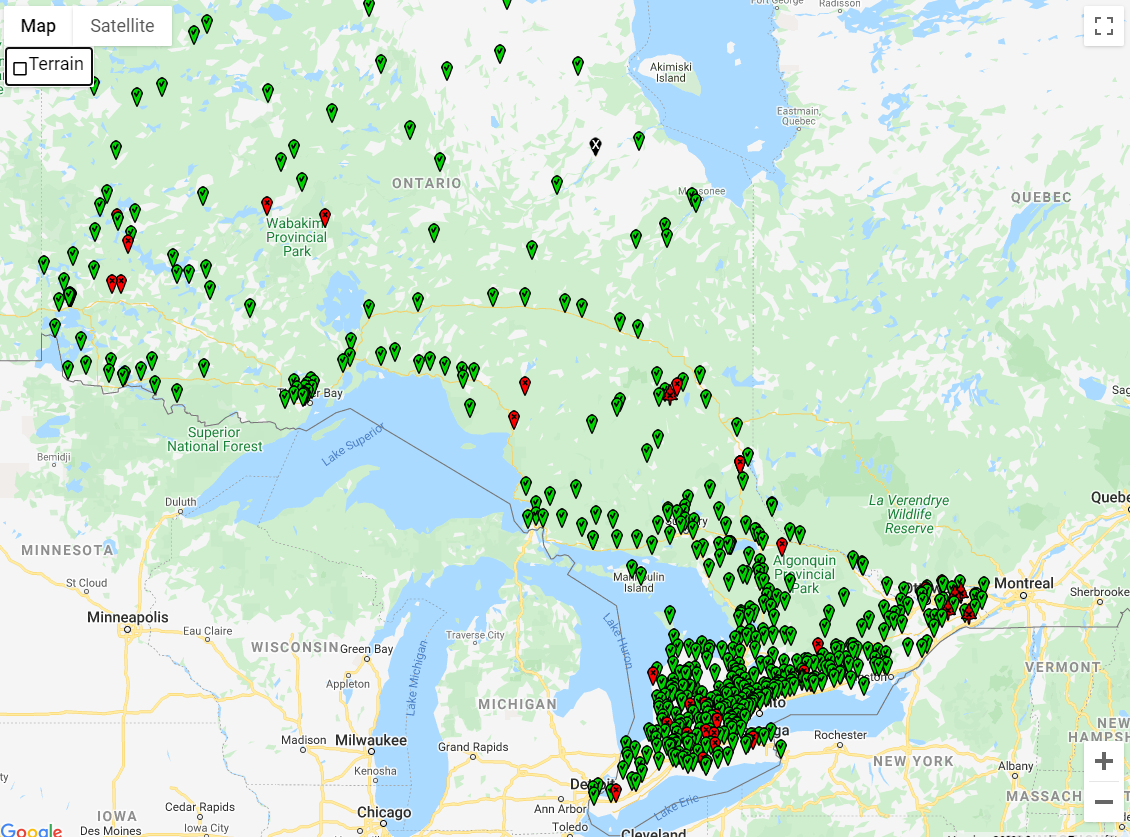

Each one of those green dots is a station that measures data from nearby rives and streams uploads data anywhere between every day to every minute and uploads it to the website. Let's see if we can pick a one and gather some data from it.

Select any hydrometric station you like. Ideally you want one that has both water level and level. Here's the one I selected:
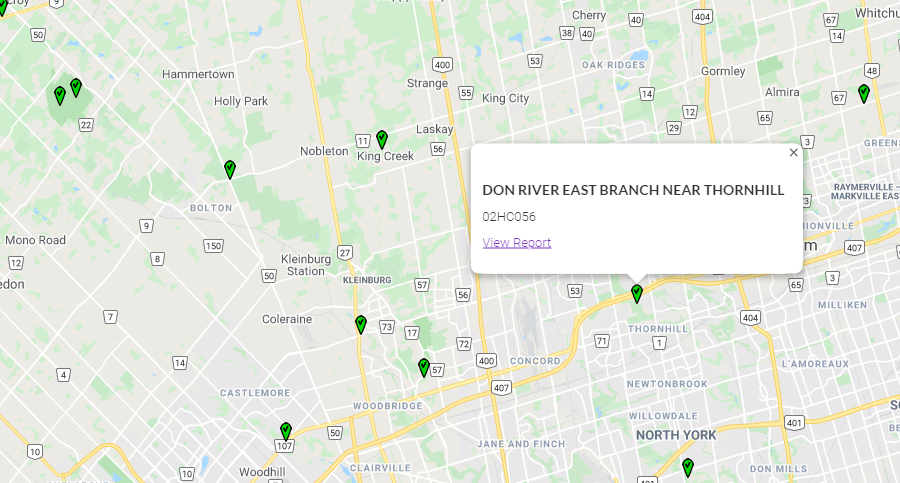

From here, click "View Report", which will open the most up-to-date data on the station. Here you can also verify that both flow and level are being measured: click "Table", and you should see columns for both water level and discharge:
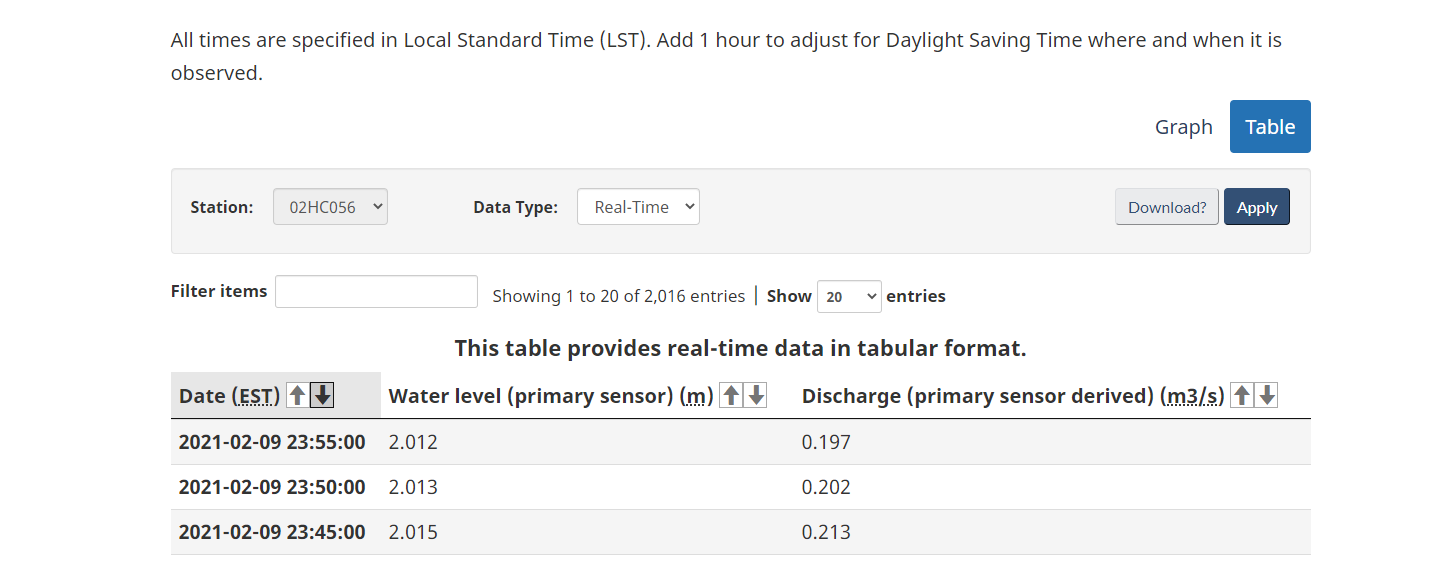


We would like to extract data over the past year. Scroll down to "Date Parameters" at the bottom, and select this date from last year. Make sure water level and discharge are in your primary and secondary axes, then click "Apply Settings" to pull up the data. After the page reloads, you can select "Download" to begin collecting your data.

Unfortunately, the Government isn't making this easy for us. The two sensors are split into two separate files:
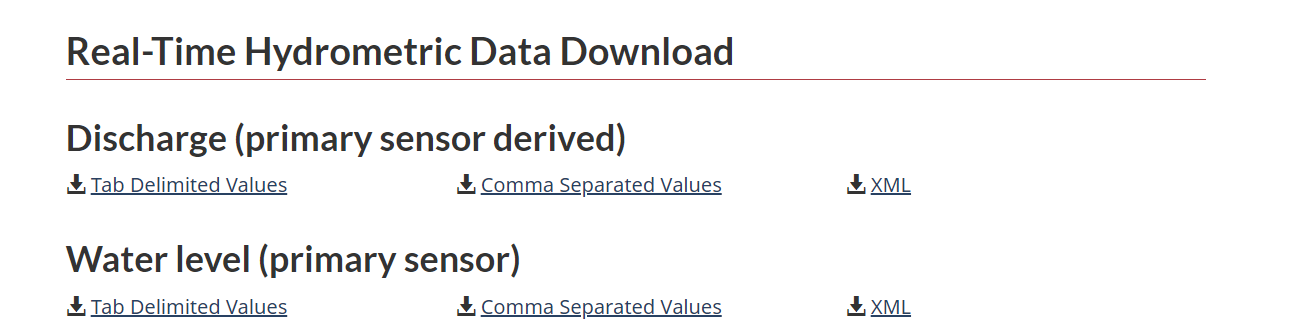
We will need to address this when we construct our data table. For now, we will download them as two separate comma separated values (csv) files.

The files will be zipped when you download them. Extract them to a folder on your computer and name them "mystation_level_data" and "mystation_discharge_data", and save them **in the same folder as this file**. Now, you can run the code below.

In [2]:
#This converts the csv file into a pandas dataframe (a special python table)
mystation_level = pd.read_csv('mystation_level_data.csv')
mystation_discharge = pd.read_csv('mystation_discharge_data.csv')

The code worked! However, look what happens when try to open it:

In [3]:
mystation_level

,Real-time data - subject to revision,Unnamed: 1,Unnamed: 2
0,Copyright Environment Canada(2021),NaN,NaN
1,NaN,NaN,NaN
2,Real-Time Hydrometric Data for DON RIVER EAST ...,NaN,NaN
3,NaN,NaN,NaN
4,02HC056,DON RIVER EAST BRANCH NEAR THORNHILL,NaN
...,...,...,...
105505,2021-02-11 9:10,46,2.009
105506,2021-02-11 9:15,46,2.011
105507,2021-02-11 9:20,46,2.012
105508,2021-02-11 9:25,46,2.013


The csv file contains several rows in a title block, which python includes as part of our dataframe, which we don't want. If we look at our csv, we see that the first 10 rows in the level spreadsheet and the first 11 rows of the discharge spreadsheet are unwanted. There are several ways to do this, the easiest of which is to use the iloc method: 

In [4]:
#Remove the first 10 rows from the dataframe
mystation_level = mystation_level.iloc[9:]
mystation_discharge = mystation_discharge.iloc[10:]
mystation_discharge

,Real-time data - subject to revision,Unnamed: 1,Unnamed: 2
10,2020-02-11 0:00,47,0.479
11,2020-02-11 0:05,47,0.479
12,2020-02-11 0:10,47,0.479
13,2020-02-11 0:15,47,0.479
14,2020-02-11 0:20,47,0.479
...,...,...,...
105506,2021-02-11 9:10,47,0.183
105507,2021-02-11 9:15,47,0.192
105508,2021-02-11 9:20,47,0.197
105509,2021-02-11 9:25,47,0.202


Recall that the loc and iloc methods basically call the positional parameters of a matrix. Also recall that by convention, Python lists start from 0, so our code in effect relabels each dataframe as the 10th (from 0 to 9) row onwards. Next, we need to rename our indices, which we can do by the following code block:

In [5]:
#Rename each column
mystation_level.columns = ['timestamp', 'parameter', 'level']
mystation_discharge.columns = ['timestamp', 'parameter', 'flow']

Now, we need to join our two dataframes. If our dates match, it would be easy enough to simply concactenate them with the join method: however, one missing date stamp and our data would be completely misaligned. Python gives us a better option of doing this using the [left merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html), which actually combines matching values in two dataframes.

In [6]:
#Create mystation_data by merging the level and discharge dataframes on the Date column
mystation_data = mystation_level.merge(mystation_discharge, how='inner', on='timestamp')
mystation_data

,timestamp,parameter_x,level,parameter_y,flow
0,2020-02-11 0:00,46,2.054,47,0.479
1,2020-02-11 0:05,46,2.054,47,0.479
2,2020-02-11 0:10,46,2.054,47,0.479
3,2020-02-11 0:15,46,2.054,47,0.479
4,2020-02-11 0:20,46,2.054,47,0.479
...,...,...,...,...,...
105496,2021-02-11 9:10,46,2.009,47,0.183
105497,2021-02-11 9:15,46,2.011,47,0.192
105498,2021-02-11 9:20,46,2.012,47,0.197
105499,2021-02-11 9:25,46,2.013,47,0.202


Great! We are almost ready to start pivoting the data. One thing we need to check is if the dates are set as strings or datetime objects. 

In [7]:
#Check the type of the first date entry in the mystation_data table
type(mystation_data.iloc[0, 0])

str

Having these values as strings makes doing any kind of pivot tables a lot harder. Thankfully there is a [pandas function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) for that. We should also convert the other values from strings to floats, since the MOE is sneaky like that. Finally, we should drop the 'Parameter_x' and 'Parameter_y' columns, since they don't tell us anything about the data:

In [8]:
#Convert dates from string objects to datetime objects
mystation_data.loc[:, 'timestamp'] = pd.to_datetime(mystation_data.loc[:, 'timestamp'], format='%Y-%m-%d %H:%M')

#Convert the level and flow values from string to float
mystation_data.loc[:, 'level'] = mystation_data.loc[:, 'level'].astype(float)
mystation_data.loc[:, 'flow'] = mystation_data.loc[:, 'flow'].astype(float)

#Drop unnecessary columns
mystation_data.drop(['parameter_x', 'parameter_y'], axis=1, inplace=True)


Now we can check if the function worked

In [9]:
#Check if the date was successful
print(type(mystation_data.iloc[0, 0]))

#Check dataframe
mystation_data

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,timestamp,level,flow
0,2020-02-11 00:00:00,2.054,0.479
1,2020-02-11 00:05:00,2.054,0.479
2,2020-02-11 00:10:00,2.054,0.479
3,2020-02-11 00:15:00,2.054,0.479
4,2020-02-11 00:20:00,2.054,0.479
...,...,...,...
105496,2021-02-11 09:10:00,2.009,0.183
105497,2021-02-11 09:15:00,2.011,0.192
105498,2021-02-11 09:20:00,2.012,0.197
105499,2021-02-11 09:25:00,2.013,0.202


Our dataframe looks good, but what happens when we try and plot it straight up?

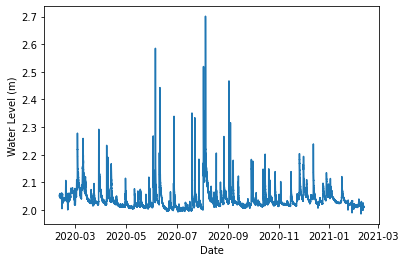

In [10]:
plt.plot(mystation_data.loc[:, 'timestamp'], mystation_data.loc[:, 'level'])
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.show()

That looks OK, but with so much data there is more we can do. We should aggregate the data, that way we can get key parameters, like means, standard deviations, etc, and use them to better understand variations in our data. We can do this using Python's pivot table functionality.

To make pivot table sorting easier, we should create columns for month, week, and day. This is easy enough to do with the datetime package, and because we converted the string objects to datetime objects above. 

In [13]:
#Generate day and month columns for each timestamp
mystation_data.loc[:,'month'] = pd.DatetimeIndex(mystation_data.loc[:,'timestamp']).month
mystation_data.loc[:,'date'] = pd.DatetimeIndex(mystation_data.loc[:,'timestamp']).date
mystation_data.loc[:,'week'] = pd.DatetimeIndex(mystation_data.loc[:,'timestamp']).week

#Rearrange columns
mystation_data = mystation_data[['timestamp', 'date', 'week', 'month', 'level', 'flow']]

mystation_data

,timestamp,date,week,month,level,flow
0,2020-02-11 00:00:00,2020-02-11,7,2,2.054,0.479
1,2020-02-11 00:05:00,2020-02-11,7,2,2.054,0.479
2,2020-02-11 00:10:00,2020-02-11,7,2,2.054,0.479
3,2020-02-11 00:15:00,2020-02-11,7,2,2.054,0.479
4,2020-02-11 00:20:00,2020-02-11,7,2,2.054,0.479
...,...,...,...,...,...,...
105496,2021-02-11 09:10:00,2021-02-11,6,2,2.009,0.183
105497,2021-02-11 09:15:00,2021-02-11,6,2,2.011,0.192
105498,2021-02-11 09:20:00,2021-02-11,6,2,2.012,0.197
105499,2021-02-11 09:25:00,2021-02-11,6,2,2.013,0.202


You can see now we have columns for each date, week (1-52) and month (1-12). Now, we can carry out pivoting, using the [pivot_table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) function to rearrange the data, and the aggfunc parameter to select what statistical function (i.e. mean, standard deviation) we want. Let's start with days:

In [14]:
#Generate a pivot table with the daily averages, minimums, maximums, and standard deviations
daily_pivot = pd.pivot_table(mystation_data, values=['level', 'flow'], index='date', 
                             aggfunc = {'level': [np.mean, np.std, max, min],
                                        'flow': [np.mean, np.std, max, min]})
daily_pivot

flow                             level                           
              max      mean    min       std    max      mean    min       std
date                                                                          
2020-02-11  0.532  0.453937  0.404  0.034995  2.060  2.050993  2.045  0.004101
2020-02-12  0.445  0.405472  0.380  0.013940  2.050  2.045153  2.042  0.001704
2020-02-13  0.551  0.416944  0.388  0.032443  2.062  2.046451  2.043  0.003836
2020-02-14  0.524  0.375049  0.165  0.086756  2.059  2.040240  2.005  0.012396
2020-02-15  0.365  0.317205  0.268  0.026738  2.040  2.033146  2.025  0.004188
...           ...       ...    ...       ...    ...       ...    ...       ...
2021-02-07  0.244  0.204403  0.090  0.037275  2.021  2.013111  1.988  0.007951
2021-02-08  0.300  0.206031  0.083  0.054995  2.031  2.013170  1.986  0.011383
2021-02-09  0.223  0.206986  0.187  0.007752  2.017  2.013931  2.010  0.001475
2021-02-10  0.272  0.198778  0.136  0.027144  2.026  2.012191  1.999  0.005408
2021-02-11  0.202  0.196435  0.183  0.005595  2.013  2.011878  2.009  0.001141

[367 rows x 8 columns]

We can repeat this for the weekly and monthly data sets as well:

In [16]:
#Generate a pivot table with the weekly averages, minimums, maximums, and standard deviations
weekly_pivot = pd.pivot_table(mystation_data, values=['level', 'flow'], index='week', 
                             aggfunc = {'level': [np.mean, np.std, max, min],
                                        'flow': [np.mean, np.std, max, min]})

#Generate a pivot table with the monthly averages, minimums, maximums, and standard deviations
monthly_pivot = pd.pivot_table(mystation_data, values=['level', 'flow'], index='month', 
                             aggfunc = {'level': [np.mean, np.std, max, min],
                                        'flow': [np.mean, np.std, max, min]})
monthly_pivot

flow                             level                           
         max      mean    min       std    max      mean    min       std
month                                                                    
1      1.160  0.332287  0.098  0.137835  2.121  2.033625  1.990  0.017551
2      0.994  0.356719  0.083  0.146084  2.107  2.036504  1.986  0.020168
3      3.060  0.613146  0.213  0.437132  2.292  2.065082  2.015  0.044679
4      2.360  0.363762  0.186  0.240460  2.234  2.036413  2.010  0.027323
5      1.140  0.252515  0.159  0.102132  2.119  2.020937  2.004  0.014796
6      7.360  0.387221  0.124  0.480925  2.585  2.035189  1.996  0.048717
7      3.820  0.240735  0.114  0.245127  2.351  2.016283  1.994  0.028153
8      9.400  0.622545  0.145  0.840893  2.701  2.061880  2.001  0.074698
9      5.490  0.355965  0.173  0.322710  2.467  2.034201  2.007  0.033961
10     2.010  0.329644  0.186  0.176588  2.202  2.032713  2.010  0.020738
11     2.030  0.386071  0.202  0.285524  2.204  2.038785  2.013  0.031420
12     2.430  0.465943  0.173  0.237544  2.239  2.050268  2.007  0.026050

We just compressed a a table with 105,500 rows into 12, using contextual variables like mean and standard deviation that can much better communicate the data. For example, we can now plot a similar figure as above, but add error bars for the standard deviation:

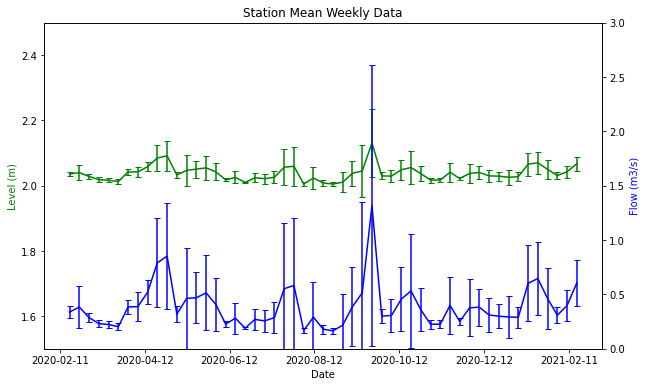

In [17]:
#Set up x and y values based on mean
x = weekly_pivot.index/4.35
y_level = weekly_pivot.loc[:, ('level', 'mean')]
y_flow = weekly_pivot.loc[:, ('flow', 'mean')]

#Set up error values based on standard deviations
ylevel_err = weekly_pivot.loc[:, ('level', 'std')]
yflow_err = weekly_pivot.loc[:, ('flow', 'std')]

#Construct plot and error bars
fig, ax1 = plt.subplots(figsize=(10, 6)) 
ax2 = ax1.twinx()
ax1.errorbar(x, y_level, yerr = ylevel_err, label ='Level (m)', color='g', capsize=3) 
ax2.errorbar(x, y_flow, yerr = yflow_err, label = 'Flow (m3/s)', color='b', capsize=3)
ax1.set_ylim([1.5,2.5])
ax2.set_ylim([0,3])

#Set up x tick labels
tot_days = daily_pivot.index[-1]-daily_pivot.index[0]
tot_days = tot_days.days
ticks_x = [0, 2, 4, 6, 8, 10, 12]
ticks_y = [daily_pivot.index[(0)],
           daily_pivot.index[round(ticks_x[1]/ticks_x[-1]*tot_days)],
           daily_pivot.index[round(ticks_x[2]/ticks_x[-1]*tot_days)],
           daily_pivot.index[round(ticks_x[3]/ticks_x[-1]*tot_days)],
           daily_pivot.index[round(ticks_x[4]/ticks_x[-1]*tot_days)],
           daily_pivot.index[round(ticks_x[5]/ticks_x[-1]*tot_days)],
           daily_pivot.index[round(ticks_x[6]/ticks_x[-1]*tot_days)]]
plt.xticks(ticks_x, ticks_y)

#Label axes
ax1.set_xlabel('Date')
ax1.set_ylabel('Level (m)', color='g')
ax2.set_ylabel('Flow (m3/s)', color='b')
plt.title('Station Mean Weekly Data')

plt.show() 


That example is just one of many possible plots we can generate. Try plotting figures for months, weeks, or days, and see if you can display the data in more interesting ways.